In [2]:
import os

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [100]:
file_name = 'df_noisy_out_census_dp_rho=0.1.csv'
df = pd.read_csv(file_name)
error = df['avg_noisy_basic_alloc'] - df['calculated_basic_alloc']

print(error.sum())
df.head()

-1.894659362733364e-08


,State FIPS Code,District ID,State,Name,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,...,saipe_children_count,saipe_children_formula_count,cv,sppe,avg_noisy_basic_alloc,avg_noisy_concentration_alloc,avg_noisy_target_alloc,calculated_basic_alloc,calculated_concentrated_alloc,calculated_targeted_alloc
0,1,190,ALABAMA,Alabaster City School District,404482.451481,159746.293284,0.000000,34669.0,6710.0,673.0,...,6710.0,649.0,0.23,9697.0,417974.322309,0.000000,176077.995220,417981.280355,0.000000,176084.866297
1,1,5,ALABAMA,Albertville City School District,738438.215814,498231.293705,180752.421632,22051.0,4131.0,970.0,...,4131.0,957.0,0.23,9697.0,602415.898590,167245.774577,290271.293200,602439.586842,167239.580002,290291.469772
2,1,30,ALABAMA,Alexander City City School District,493947.426734,353662.302968,122103.107993,16920.0,2575.0,708.0,...,2575.0,703.0,0.28,9697.0,439660.545063,122060.805083,187426.645441,439718.791221,122067.652208,187466.280389
3,1,60,ALABAMA,Andalusia City School District,245814.743916,144408.067790,62375.463078,8842.0,1465.0,409.0,...,1465.0,406.0,0.35,9697.0,253953.249102,70503.799048,106981.561804,254018.341256,70516.482702,107011.456635
4,1,90,ALABAMA,Anniston City School District,662918.490317,510408.966121,168215.490893,22043.0,2957.0,1103.0,...,3065.0,1057.0,0.23,9697.0,685087.865850,190197.600463,342511.477940,685042.128131,190170.367776,342488.989573


In [101]:
df['avg_noisy_concentrated_alloc'] = df['avg_noisy_concentration_alloc']
df['avg_noisy_targeted_alloc'] = df['avg_noisy_target_alloc']

df['calculated_total_alloc'] = df['calculated_basic_alloc'] + df['calculated_concentrated_alloc'] + df[
    'calculated_targeted_alloc']

df['avg_noisy_total_alloc'] = df['avg_noisy_basic_alloc'] + df['avg_noisy_concentrated_alloc'] + df[
    'avg_noisy_targeted_alloc']

df['official_children_formula_proportion'] = df['official_children_formula_count'] / df['official_children_count']
df['official_children_formula_proportion']

0        0.100298
1        0.234810
2        0.274951
3        0.279181
4        0.373013
           ...   
13185    0.039402
13186    0.116602
13187    0.133333
13188    0.153186
13189    0.056225
Name: official_children_formula_proportion, Length: 13190, dtype: float64

In [102]:
basic_error = df['avg_noisy_basic_alloc'] - df['calculated_basic_alloc']
conc_error = df['avg_noisy_concentration_alloc'] - df['calculated_concentrated_alloc']
targ_error = df['avg_noisy_target_alloc'] - df['calculated_targeted_alloc']

print('basic_error', basic_error.sum())
print('conc_error', conc_error.sum())
print('targeted_error', targ_error.sum())

basic_error -1.894659362733364e-08
conc_error 1.7920683603733778e-07
targeted_error 6.443588063120842e-08


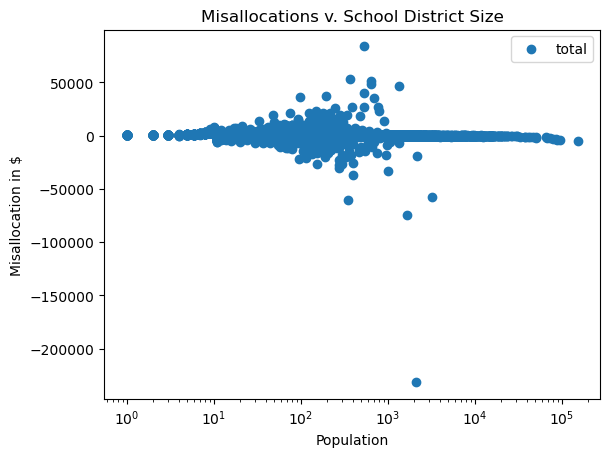

In [105]:
def plot_misallocations_over_all_states(allocs):
    for alloc in allocs:
        errors = df[f'avg_noisy_{alloc}_alloc'] - df[f'calculated_{alloc}_alloc']
        plt.scatter(df['official_children_formula_count'], errors, label=alloc)

    plt.title('Misallocations v. School District Size')
    plt.xlabel('Population')
    plt.ylabel('Misallocation in $')
    plt.xscale('log')
    plt.legend()
    plt.show()


# plot_misallocations_over_all_states(['basic', 'concentrated', 'targeted'])
plot_misallocations_over_all_states(['total'])


In [72]:
# Misallocations per State
df_grp_states = df.groupby('State FIPS Code')


def save_misallocs_per_state_graphs(allocs):
    for key in df_grp_states.groups.keys():
        df_state = df.loc[df_grp_states.groups[key]]
        state = df_state['State'].values[0]

        for alloc in allocs:
            errors = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']

            # plt.scatter(df_state['official_children_count'], errors, label='total children pop')
            plt.scatter(df_state['official_children_formula_count'], errors, label=alloc)

        plt.title(state)
        plt.xlabel('Population')
        plt.ylabel('Misallocation in $')

        plt.xscale('log')

        save_loc = f'../out/new_outputs/{file_name}/{state}.png'
        os.makedirs(os.path.dirname(save_loc), exist_ok=True)
        plt.legend()
        plt.savefig(save_loc)
        plt.clf()


save_misallocs_per_state_graphs(['basic', 'concentrated', 'targeted'])

<Figure size 640x480 with 0 Axes>

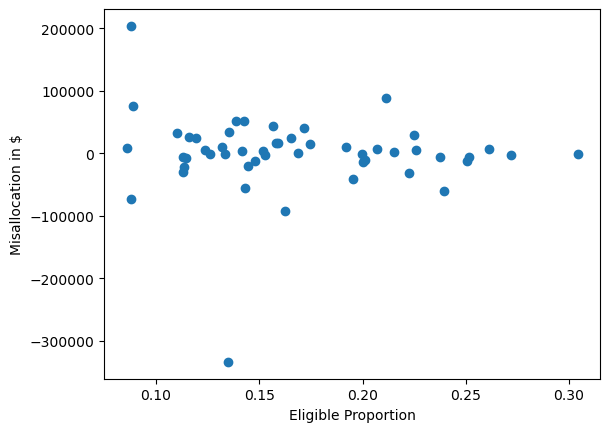

In [61]:
def plot_errors_by_x(alloc, x, log_scale=True, average=False, xlabel='Eligible Population'):
    df_state_by_state = {'errors': [], 'x': []}
    for key in list(df_grp_states.groups.keys()):
        df_state = df.loc[df_grp_states.groups[key]]
        errors = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']

        df_state_by_state['errors'].append(errors.sum())
        df_state_by_state['x'].append(df_state[x].sum() / (1 if not average else len(df_state)))

    plt.scatter(df_state_by_state['x'], df_state_by_state['errors'])
    if log_scale:
        plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Misallocation in $')
    # plt.legend()
    plt.show()

plot_errors_by_x('total', 'official_children_formula_proportion', log_scale=False, average=True, xlabel='Eligible Proportion')

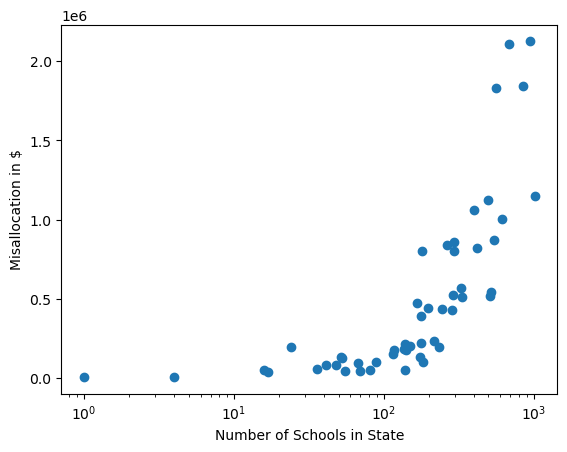

In [76]:
alloc = 'total'
df_state_by_state = {'errors': [], 'x': []}
for key in list(df_grp_states.groups.keys()):
    df_state = df.loc[df_grp_states.groups[key]]
    errors = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']

    df_state_by_state['errors'].append(abs(errors).sum())
    df_state_by_state['x'].append(len(df_state))

plt.scatter(df_state_by_state['x'], df_state_by_state['errors'])
plt.xscale('log')
plt.xlabel('Number of Schools in State')
plt.ylabel('Misallocation in $')
# plt.legend()
plt.show()


In [52]:
_tmp = df[df['State'] == 'TEXAS']
e = np.abs(_tmp['avg_noisy_total_alloc'] - _tmp['calculated_total_alloc'])
_tmp['total_errors'] = e
_tmp = _tmp[e > 1000]
_tmp[['official_children_formula_count', 'official_children_count', 'calculated_basic_alloc', 'avg_noisy_basic_alloc',
      'calculated_concentrated_alloc', 'avg_noisy_concentration_alloc', 'calculated_targeted_alloc',
      'avg_noisy_target_alloc', 'calculated_total_alloc', 'avg_noisy_total_alloc', 'total_errors']].sort_values(
    by='official_children_count')


/var/folders/_0/j0skcttj3nx9079xgvyy1gt00000gn/T/ipykernel_56175/1661208037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp['total_errors'] = e


,official_children_formula_count,official_children_count,calculated_basic_alloc,avg_noisy_basic_alloc,calculated_concentrated_alloc,avg_noisy_concentration_alloc,calculated_targeted_alloc,avg_noisy_target_alloc,calculated_total_alloc,avg_noisy_total_alloc,total_errors
11768,13.0,33.0,8.073933e+03,7.229769e+03,2.241355e+03,2.247063e+03,3.474623e+03,3.073091e+03,1.378991e+04,1.254992e+04,1239.988962
11990,6.0,40.0,0.000000e+00,6.639143e+02,0.000000e+00,7.310962e+02,0.000000e+00,2.804403e+02,0.000000e+00,1.675451e+03,1675.450829
11797,8.0,40.0,0.000000e+00,1.283111e+03,1.379296e+03,1.202341e+03,0.000000e+00,5.405279e+02,1.379296e+03,3.025980e+03,1646.684249
11926,6.0,44.0,0.000000e+00,6.278940e+02,0.000000e+00,6.086958e+02,0.000000e+00,2.645067e+02,0.000000e+00,1.501097e+03,1501.096555
11815,12.0,46.0,7.452861e+03,6.087640e+03,2.068943e+03,2.017757e+03,3.139700e+03,2.564858e+03,1.266150e+04,1.067025e+04,1991.250018
...,...,...,...,...,...,...,...,...,...,...,...
11690,599.0,3964.0,3.720220e+05,3.720589e+05,1.032748e+05,9.543241e+04,1.567234e+05,1.567355e+05,6.320201e+05,6.242268e+05,7793.287184
11683,86.0,3972.0,5.341217e+04,5.220203e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.341217e+04,5.220203e+04,1210.140564
11660,607.0,4086.0,3.769905e+05,3.769255e+05,0.000000e+00,3.289510e+03,1.588165e+05,1.587856e+05,5.358071e+05,5.390007e+05,3193.634104
11353,50220.0,193595.0,3.119022e+07,3.118958e+07,8.658528e+06,8.659247e+06,3.336036e+07,3.335893e+07,7.320911e+07,7.320776e+07,1351.815782


In [ ]:
def interpolate_colors(start_color, end_color, num_steps):
    # Convert the start and end colors to RGB tuples
    start_rgb = tuple(int(start_color[i:i + 2], 16) for i in (0, 2, 4))
    end_rgb = tuple(int(end_color[i:i + 2], 16) for i in (0, 2, 4))

    # Compute the step size for each color channel
    step_size = [int((end - start) / (num_steps - 1)) for start, end in zip(start_rgb, end_rgb)]

    # Yield the interpolated colors
    for i in range(num_steps):
        # Compute the color values for this step
        r = start_rgb[0] + step_size[0] * i
        g = start_rgb[1] + step_size[1] * i
        b = start_rgb[2] + step_size[2] * i

        # Yield the color as a hex string
        yield "#{:02x}{:02x}{:02x}".format(r, g, b)


colors = interpolate_colors("0000ff", "ff0000", 50)
for key in list(df_grp_states.groups.keys())[:]:
    df_state = df.loc[df_grp_states.groups[key]]
    errors = df_state['avg_noisy_basic_alloc'] - df_state['calculated_basic_alloc']
    df_state['errors'] = errors
    plt.scatter(df_state['official_children_formula_count'], errors, label=df_state['State'].iloc[0])
plt.xscale('log')
plt.xlabel('Formula Population')
plt.ylabel('Misallocation in $')
# plt.legend()
plt.show()

(df_state[(errors.abs() > 2500) & (df_state['official_children_formula_count'] > 10)])



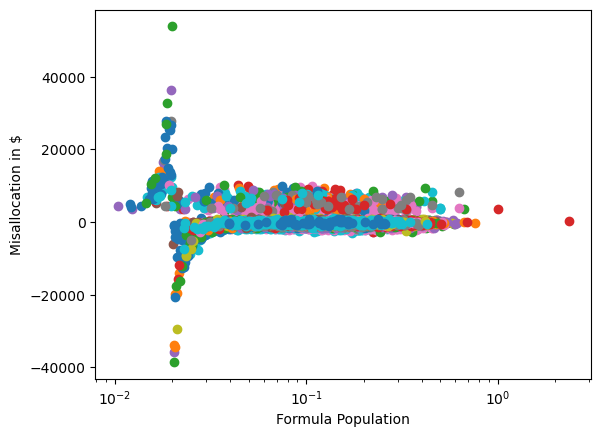

,State FIPS Code,District ID,State,Name,basic_alloc,official_population_count,official_children_count,official_children_formula_count,State Postal Code,saipe_population_count,saipe_children_count,saipe_children_formula_count,cv,sppe,avg_noisy_basic_alloc,calculated_basic_alloc,errors


In [120]:
# plot misallocation by fraction of population that is in poverty
for key in list(df_grp_states.groups.keys())[:]:
    df_state = df.loc[df_grp_states.groups[key]]
    errors = df_state['avg_noisy_basic_alloc'] - df_state['calculated_basic_alloc']
    frac_poverty = df_state['official_children_formula_count'] / df_state['official_children_count']
    df_state['errors'] = errors
    plt.scatter(frac_poverty, errors, label=df_state['State'].iloc[0])
plt.xscale('log')
plt.xlabel('Formula Population')
plt.ylabel('Misallocation in $')
# plt.legend()
plt.show()

(df_state[(errors.abs() > 2500) & (df_state['official_children_formula_count'] > 10)])



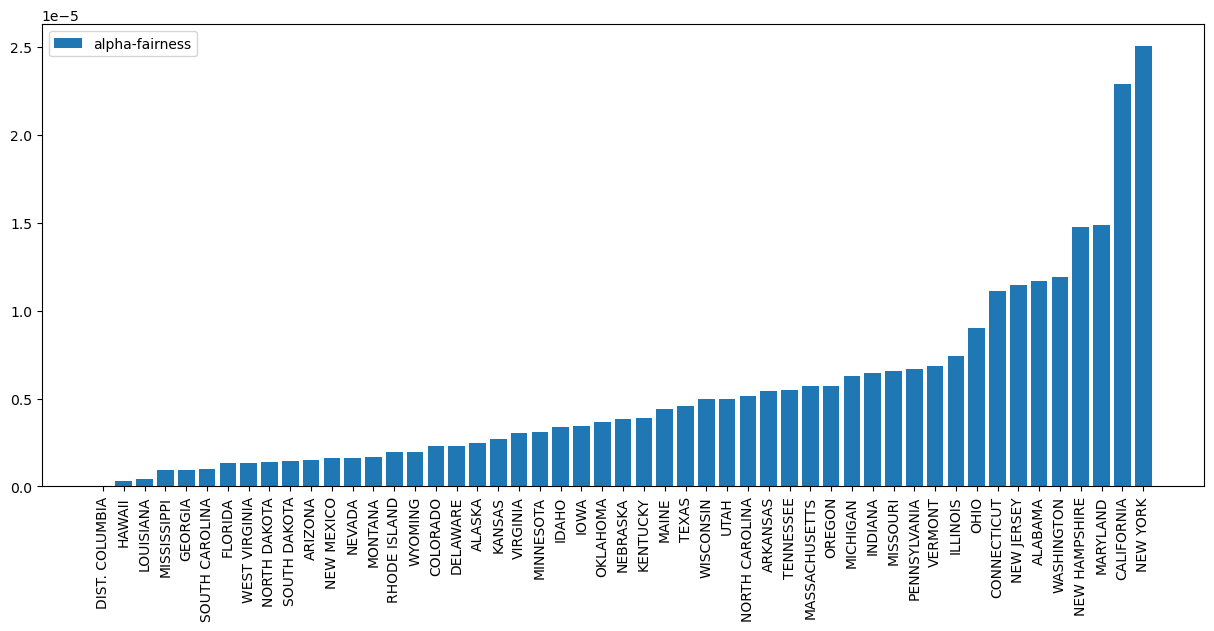

In [73]:

from collections import defaultdict

# compute alpha fairness

stats_by_state = defaultdict(lambda: [].copy())
total_funds = {
    'basic': df['basic_alloc'].sum(),
    'concentrated': df['concentration_alloc'].sum(),
    'targeted': df['targeted_alloc'].sum()
}
total_funds['total'] = total_funds['basic'] + total_funds['concentrated'] + total_funds['targeted']
for key in df_grp_states.groups.keys():
    for alloc in ['total']:
        df_state = df.loc[df_grp_states.groups[key]]
        bias = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']
        alpha_fairness = (max(bias) - min(bias)) / total_funds[alloc]
        total_children_population = sum(df_state['official_children_count'])
        formula_children_population = sum(df_state['official_children_formula_count'])
        total_population = sum(df_state['official_population_count'])

        stats_by_state['alpha_fairness'].append(alpha_fairness)
        stats_by_state['children_population'].append(total_children_population)
        stats_by_state['children_formula_population'].append(formula_children_population)
        stats_by_state['total_population'].append(total_population)
        stats_by_state['state'].append(df_state['State'].iloc[0])

stats_by_state_df = pd.DataFrame(stats_by_state)

# plot histogram
stats_by_state_df = stats_by_state_df.sort_values(by=['alpha_fairness'])
plt.figure(figsize=(15, 6))
plt.bar(stats_by_state_df['state'], stats_by_state_df['alpha_fairness'], label='alpha-fairness')
plt.xticks(rotation=90)
plt.legend()
plt.show()




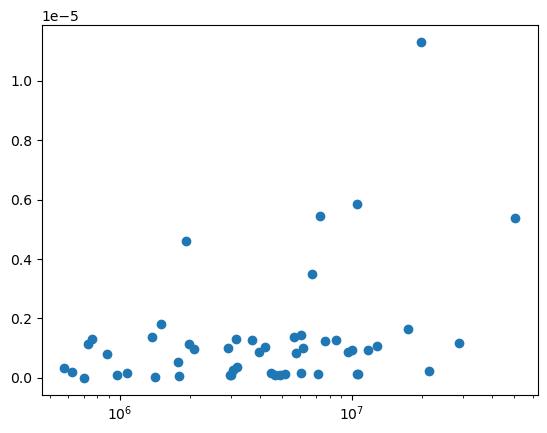

In [35]:
plt.scatter(stats_by_state_df['total_population'], stats_by_state_df['alpha_fairness'])
plt.xscale('log')


/var/folders/_0/j0skcttj3nx9079xgvyy1gt00000gn/T/ipykernel_25802/306450481.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


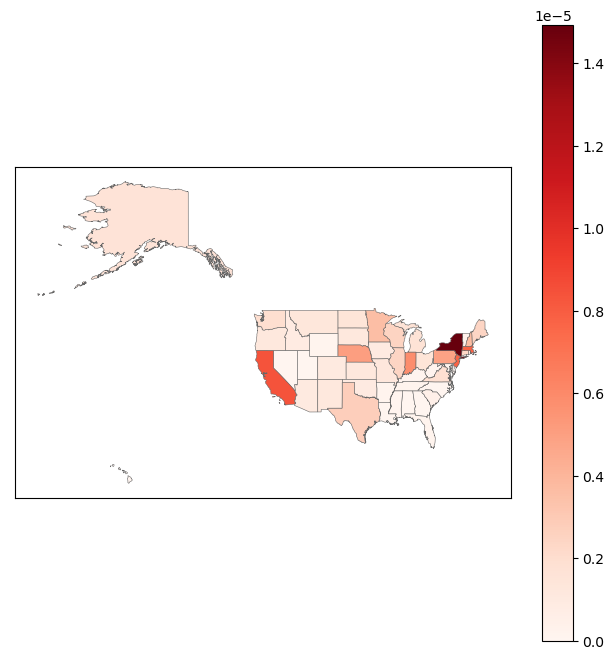

In [122]:
import geopandas as gpd

usa = gpd.read_file('../states.shp')
usa['state'] = usa['state_name'].str.upper()
usa = usa.merge(stats_by_state_df, on='state')

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks([])
plt.yticks([])

values = stats_by_state_df['alpha_fairness']

usa.plot(column="alpha_fairness", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
#
bar_info = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=np.min(values), vmax=np.max(values)))
bar_info._A = []
cbar = fig.colorbar(bar_info)
plt.show()
